# ***MAKEMORE: NLP MODEL WITH EMBEDDINGS, LR DECAY AND BATCH SPLITS***

### Importing Libs

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

### Reading list of names (all lowered already)

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### Building vocab of chars and mapping into integers

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build dataset

In [4]:
block_size = 3
X, Y = [], []
for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

### Train Test Validation splits

In [5]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context.copy())
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

# 80% train, 10% validation, 10% test
train = words[:int(.8 * len(words))]
valid = words[int(.8 * len(words)):int(.9 * len(words))]
test = words[int(.9 * len(words)):]

X_train, Y_train = build_dataset(train)
X_valid, Y_valid = build_dataset(valid)
X_test, Y_test = build_dataset(test)

In [6]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

### MLP
Adjusting the intialization weights so that the gaussians keep std =~ 1. More details on <a href="https://pytorch.org/docs/stable/nn.init.html"> this link </a>



In [ ]:
g = torch.Generator().manual_seed(42)
# Embedding matrix
n_emb = 10
n_hidden = 200
C = torch.randn((27, n_emb), generator=g)
# MLP weights and biases
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3)/((n_emb*block_size + n_hidden)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

### Check how gaussians behave through forward pass

tensor(0.0045) tensor(0.9947)
tensor(0.0006) tensor(0.9846)


(array([6.0000e+00, 1.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        7.0000e+00, 1.3000e+01, 9.0000e+00, 1.4000e+01, 2.4000e+01,
        3.4000e+01, 4.7000e+01, 6.9000e+01, 9.2000e+01, 1.1900e+02,
        1.5000e+02, 2.0400e+02, 2.7200e+02, 3.8100e+02, 4.4800e+02,
        6.4100e+02, 7.9200e+02, 1.0700e+03, 1.4130e+03, 1.7800e+03,
        2.2340e+03, 2.8250e+03, 3.6760e+03, 4.6550e+03, 5.7930e+03,
        7.2440e+03, 9.0520e+03, 1.1198e+04, 1.3401e+04, 1.6163e+04,
        1.9517e+04, 2.2864e+04, 2.6845e+04, 3.0859e+04, 3.5478e+04,
        3.9744e+04, 4.3488e+04, 4.7055e+04, 5.0675e+04, 5.2224e+04,
        5.3403e+04, 5.3211e+04, 5.1864e+04, 4.9499e+04, 4.6566e+04,
        4.2780e+04, 3.8624e+04, 3.4456e+04, 3.0246e+04, 2.5853e+04,
        2.2225e+04, 1.8678e+04, 1.5613e+04, 1.2755e+04, 1.0644e+04,
        8.6220e+03, 6.9260e+03, 5.5400e+03, 4.3010e+03, 3.5090e+03,
        2.7660e+03, 2.1540e+03, 1.7080e+03, 1.3230e+03, 9.8500e+02,
        7.4900e+02, 6.0400e+02, 4.3700e+02, 3.45

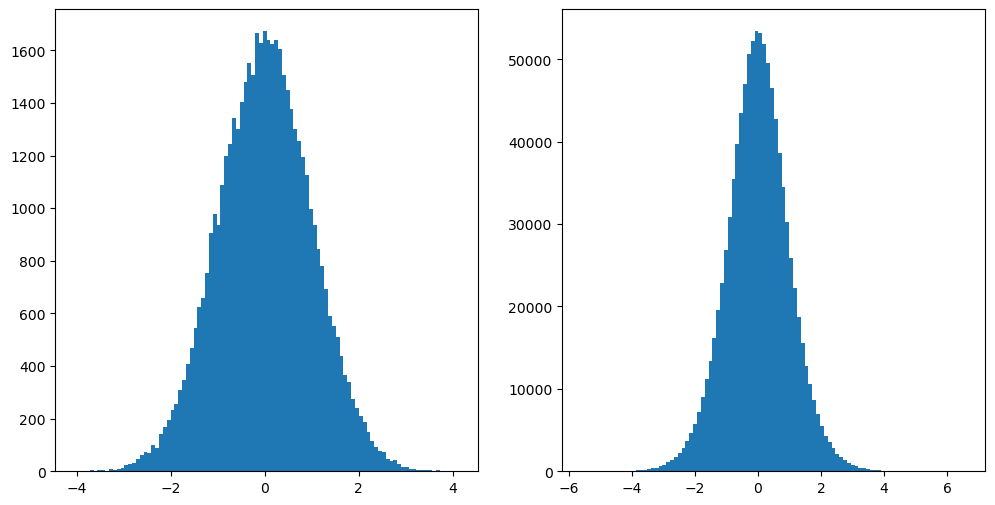

In [17]:
x = torch.randn(5000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(x.view(-1), bins=100)
plt.subplot(122)
plt.hist(y.view(-1), bins=100)

### Training the MLP

In [22]:
h_preact = embcat @ W1 + b1 # hidden pre-activation
h_preact = (h_preact - h_preact.mean(0, keepdims=True)) / h_preact.std(0, keepdims=True) # batch normalization

In [28]:
h_preact.shape

torch.Size([32, 200])

In [19]:
lossi = []
lri = []
stepi = []
losses = []
n_steps = 100000
batch_size = 32
for i in range(n_steps):
    # Minibatch Creation
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]
    
    # Forward
    emb = C[Xb] #Take the embeddings
    embcat = emb.view(emb.shape[0], -1) #concatenate the embeddings (flatten)
    h_preact = embcat @ W1 + b1 # hidden pre-activation
    h_preact = (h_preact - h_preact.mean(0, keepdims=True)) / h_preact.std(0, keepdims=True) # batch normalization
    h = torch.tanh(h_preact) # hidden activation
    logits = h @ W2 + b2 #  output layer (numerical values)
    # Neg Log lokelihood
    loss = F.cross_entropy(logits, Y[ix])
    
    #Backward
    for p in params:
        p.grad = None
    loss.backward() 
    
    # update params
    lr = 0.1 if i < int(.5*n_steps) else 0.01
    # lr = lri[i]
    for p in params:
        p.data += -p.grad * lr
    # lossi.append(loss.item())
    # lri.append(lr)
    
    # track metrics
    if i%10000 == 0:
        print(f'{i:7d}/{n_steps:7d} Loss: {loss.item():.4f}')
    stepi.append(i)
    losses.append(loss.log10().item())
    #break

      0/ 100000 Loss: 3.3931
  10000/ 100000 Loss: 2.6090
  20000/ 100000 Loss: 2.8552
  30000/ 100000 Loss: 2.8649
  40000/ 100000 Loss: 3.0570
  50000/ 100000 Loss: 2.9011
  60000/ 100000 Loss: 2.5954
  70000/ 100000 Loss: 2.6742
  80000/ 100000 Loss: 2.9808
  90000/ 100000 Loss: 2.9436


## Visualize Losses

Text(0, 0.5, 'Loss')

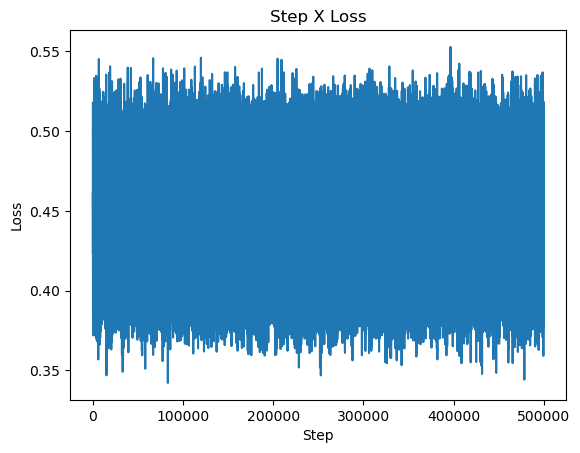

In [10]:
plt.plot(stepi, losses)
plt.title("Step X Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

In [ ]:
# plt.subplots(1, 2, figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(lri, lossi)
# plt.title("Learning Rate X Loss")
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.subplot(1, 2, 2)
# plt.plot(lre, lossi)
# plt.title("Exp Learning Rate X Loss")
# plt.xlabel("Exp Learning Rate")
# plt.ylabel("Loss")


## Eval on test and on train set to check over/underfitting

In [12]:
# Evaluate on test set
emb = C[X_test]
h = torch.tanh(emb.view(-1, block_size*n_emb) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print(f'Test loss: {loss.item()}')

# Evaluate on train set
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size*n_emb) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(f'Train loss: {loss.item()}')

Test loss: 2.8262856006622314
Train loss: 2.8240487575531006


## Visualize embeddings

In [ ]:
C[:, 1]

tensor([ 0.0147,  0.0625, -0.0673,  0.0812,  0.0327, -0.0849,  0.0482,  0.0849,
         0.0116,  0.0620,  0.0408,  0.0190,  0.0013, -0.0472,  0.0286,  0.0121,
         0.1128,  0.0411,  0.0101, -0.0239, -0.0531,  0.0226, -0.1596, -0.0011,
         0.0309, -0.0318,  0.0730], grad_fn=<SelectBackward0>)

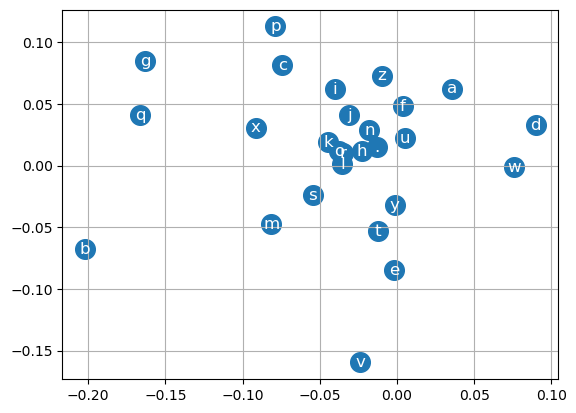

In [ ]:
# plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], fontsize=12, ha="center", va="center", color="white")
plt.grid('minor')

## Sampling from the model

In [13]:
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    print(''.join([itos[i] for i in out]))

iparyvsoawitvaolmaaloroj.
kaaymneaaarliuah.
leeri.
.
lbny.
rraoka.
t.
.
keay.
eknaemez.
arar.
r.
inmtisa.
ny.
egeelnrcsiaaijhyl.
hat.
tilgr.
.
lana.
lhsa.
